# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

***

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns

sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

***

## Содержание:
* [1. Общая информация](#section_1)
* [2. Подготовка данных](#section_2)
* [3. Помесячная выручка с каждого пользователя](#section_3)

## 1. Общая информация <a class="anchor" id="section_1"></a>

In [2]:
users_df = pd.read_csv('datasets/users.csv')
messages_df = pd.read_csv('datasets/messages.csv')
calls_df = pd.read_csv('datasets/calls.csv')
internet_df = pd.read_csv('datasets/internet.csv', )
tariffs_df = pd.read_csv('datasets/tariffs.csv')

При попытке посмотреть `calls_df.info()` вышла следующая ошибка:

`TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type`

Похожая проблема обсуждалась __[здесь](https://github.com/numpy/numpy/issues/18355)__. В итоге (загадочным образом) помогло:

`conda install pandas`

Дальше разбираться не стал.

### users

In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


- `user_id` — уникальный идентификатор пользователя

- `first_name` — имя пользователя

- `last_name` — фамилия пользователя

- `age` — возраст пользователя (годы)

- `reg_date` — дата подключения тарифа (день, месяц, год)

- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

- `city` — город проживания пользователя

- `tarif` — название тарифного плана


> Много пропусков в `churn_date`, но они объяснены в описании данных

### messages

In [5]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
messages_df.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

In [7]:
print(f'Информация по сообщениям есть для {len(messages_df.user_id.unique()) / users_df.shape[0] :.0%} пользователей')

Информация по сообщениям есть для 85% пользователей


### calls

In [8]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls_df.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

In [10]:
print(f'Информация по звонкам есть для {len(calls_df.user_id.unique()) / users_df.shape[0] :.0%} пользователей')

Информация по звонкам есть для 98% пользователей


### internet

In [11]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [12]:
internet_df.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

In [13]:
print(f'Информация по интернет-сессиям есть для {len(internet_df.user_id.unique()) / users_df.shape[0] :.0%} пользователей')

Информация по интернет-сессиям есть для 99% пользователей


### tariffs

In [14]:
tariffs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [15]:
tariffs_df

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [16]:
# Поиск дубликатов в данных

for df in [users_df, messages_df, calls_df, internet_df, tariffs_df]:
    print(df.duplicated().sum())

0
0
0
0
0


### Вывод

> - Дубликаты в таблицах отсутствуют
> - Требуется преобразование типов данных в некоторых колонках

## 2. Подготовка данных <a class="anchor" id="section_2"></a>

In [17]:
def date_convert(dates):
    """
    Преобразование типа данных в `dates` по шаблону

    Args:
        dates (pd.Series): Исходная колонка с датами

    Returns:
        pd.Series: Преобразованная колонка
    """    

    return pd.to_datetime(dates, format='%Y-%m-%d', errors='coerce')

In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [19]:
users_df['churn_date'] = users_df['churn_date'].apply(date_convert)
users_df['reg_date'] = users_df['reg_date'].apply(date_convert)


messages_df['message_date'] = messages_df['message_date'].apply(date_convert)
# В каком месяце совершено действие?
messages_df['month'] = messages_df['message_date'].dt.month
messages_df = messages_df.rename(columns={'id': 'message_id'})

calls_df['call_date'] = calls_df['call_date'].apply(date_convert)
# В каком месяце совершено действие?
calls_df['month'] = calls_df['call_date'].dt.month
calls_df = calls_df.rename(columns={'id': 'call_id'})

internet_df['session_date'] = internet_df['session_date'].apply(date_convert)
# В каком месяце совершено действие?
internet_df['month'] = internet_df['session_date'].dt.month
internet_df = internet_df.rename(columns={'id': 'session_id'})

# Проверка
for df in [users_df, messages_df, calls_df, internet_df]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   message_id    123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 n

❓: Заметил, что apply() работает довольно медленно. Он выполняет операции поэлементно?

В таблице `internet_df` содержится колонка, дублирующая индексы. Вероятно, при сохранении датафрейма не был установлен флаг `index=False`.

Удалю эту колонку.

In [20]:
internet_df.columns

Index(['Unnamed: 0', 'session_id', 'mb_used', 'session_date', 'user_id',
       'month'],
      dtype='object')

In [21]:
internet_df = internet_df.drop(['Unnamed: 0'], axis=1)

# Проверка
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


> - Привел колонки с датами к типу datetime64 (с учетом пропусков)
> - Убрал неинформативную колонку из `internet_df`

### Округление звонков

In [22]:
calls_df

,call_id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [23]:
# После округления в большую сторону поменяю тип на int
calls_df['duration'] = np.ceil(calls_df['duration']).astype(int)

calls_df

,call_id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


### Объединение данных в одну таблицу

In [24]:
for df in [users_df, messages_df, calls_df, internet_df]:
    print(df.columns)

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
Index(['message_id', 'message_date', 'user_id', 'month'], dtype='object')
Index(['call_id', 'call_date', 'duration', 'user_id', 'month'], dtype='object')
Index(['session_id', 'mb_used', 'session_date', 'user_id', 'month'], dtype='object')


In [25]:
# Назначаю индекс для упрощения представления

users_df = users_df.set_index('user_id')
messages_df = messages_df.set_index('user_id')
calls_df = calls_df.set_index('user_id')
internet_df = internet_df.set_index('user_id')

In [26]:
user_calls = users_df[['tariff']].merge(calls_df, left_index=True, right_index=True)

user_calls

,tariff,call_id,call_date,duration,month
user_id,,,,,
1000,ultra,1000_0,2018-07-25,0,7
1000,ultra,1000_1,2018-08-17,0,8
1000,ultra,1000_2,2018-06-11,3,6
1000,ultra,1000_3,2018-09-21,14,9
1000,ultra,1000_4,2018-12-15,6,12
...,...,...,...,...,...
1499,smart,1499_215,2018-12-26,1,12
1499,smart,1499_216,2018-10-18,19,10
1499,smart,1499_217,2018-11-10,11,11


## 3. Помесячная выручка с каждого пользователя <a class="anchor" id="section_3"></a>

In [72]:
# Параметры тарифов
smart_parameters = tariffs_df[tariffs_df['tariff_name']=='smart']
ultra_parameters = tariffs_df[tariffs_df['tariff_name']=='ultra']

In [71]:
# Параметры тарифов
smart_minutes_limit = smart_parameters['minutes_included'].values[0]
smart_overpay_minute = smart_parameters['rub_per_minute'].values[0]

ultra_minutes_limit = ultra_parameters['minutes_included'].values[0]
ultra_overpay_minute = ultra_parameters['rub_per_minute'].values[0]

### 3.1 Количество сделанных звонков и израсходованных минут разговора по месяцам

Сначала разберусь с пользователями тарифа `smart`:

In [28]:
def calls_revenue(calls_tarif_df,
                  minutes_tariff,
                  overpay_minute):
    """
    Вычисляет суммарную выручку за звонки

    Args:
        calls_tarif_df (_type_): _description_
        minutes_tariff (_type_): _description_
        overpay_minute (_type_): _description_
        tariff_payment (_type_): _description_

    Returns:
        _type_: _description_
    """

    # Количество звонков и их совокупная длительность
    calls_stat_df = (
        calls_tarif_df
        .groupby([calls_tarif_df.index, 'month'])['duration']
        .agg(['count', 'sum'])
        )

    calls_stat_df.columns = ['calls_count', 'call_duration']

    # Остаток по минутам
    calls_stat_df['minutes_left'] = minutes_tariff - calls_stat_df['call_duration']

    # Перебор по минутам
    minutes_left = calls_stat_df['minutes_left']
    calls_stat_df['minutes_over'] = np.where(minutes_left < 0, minutes_left, 0)
    calls_stat_df['minutes_over'] = calls_stat_df['minutes_over'].abs()

    # Переплата по минутам
    calls_stat_df['call_overpay'] = calls_stat_df['minutes_over'] * overpay_minute

    return calls_stat_df

In [29]:
calls_smart_df = user_calls[user_calls['tariff']=='smart']

calls_smart_df

,tariff,call_id,call_date,duration,month
user_id,,,,,
1001,smart,1001_0,2018-11-13,11,11
1001,smart,1001_1,2018-12-14,16,12
1001,smart,1001_2,2018-11-20,3,11
1001,smart,1001_3,2018-12-27,8,12
1001,smart,1001_4,2018-11-19,20,11
...,...,...,...,...,...
1499,smart,1499_215,2018-12-26,1,12
1499,smart,1499_216,2018-10-18,19,10
1499,smart,1499_217,2018-11-10,11,11


In [30]:
smart_calls_stat_df = calls_revenue(calls_tarif_df=calls_smart_df,
                                    minutes_tariff=smart_minutes_limit,
                                    overpay_minute=smart_overpay_minute)

smart_calls_stat_df

calls_count  call_duration  minutes_left  minutes_over  \
user_id month                                                           
1001    11              59            430            70             0   
        12              63            414            86             0   
1002    6               15            117           383             0   
        7               26            214           286             0   
        8               42            289           211             0   
...                    ...            ...           ...           ...   
1498    10              41            247           253             0   
1499    9                9             70           430             0   
        10              68            449            51             0   
        11              74            612          -112           112   
        12              69            492             8             0   

               call_overpay  
user_id month                
1001    11                0  
        12                0  
1002    6                 0  
        7                 0  
        8                 0  
...                     ...  
1498    10                0  
1499    9                 0  
        10                0  
        11              336  
        12                0  

[2223 rows x 5 columns]

In [31]:
calls_ultra_df = user_calls[user_calls['tariff']=='ultra']

calls_ultra_df.shape

(72292, 5)

In [32]:
ultra_calls_stat_df = calls_revenue(calls_tarif_df=calls_ultra_df,
                                    minutes_tariff=ultra_minutes_limit,
                                    overpay_minute=ultra_overpay_minute)

ultra_calls_stat_df

calls_count  call_duration  minutes_left  minutes_over  \
user_id month                                                           
1000    5               22            159          2841             0   
        6               43            172          2828             0   
        7               47            340          2660             0   
        8               52            408          2592             0   
        9               58            466          2534             0   
...                    ...            ...           ...           ...   
1495    8               17             92          2908             0   
        9              112            813          2187             0   
        10             152           1030          1970             0   
        11             129            954          2046             0   
        12             155           1031          1969             0   

               call_overpay  
user_id month                
1000    5                 0  
        6                 0  
        7                 0  
        8                 0  
        9                 0  
...                     ...  
1495    8                 0  
        9                 0  
        10                0  
        11                0  
        12                0  

[951 rows x 5 columns]

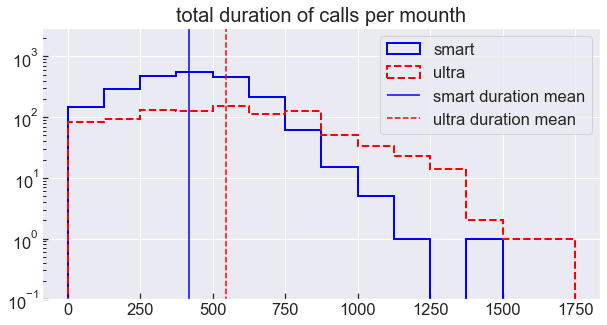

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

space = np.linspace(0, 1750, 15)

ax.hist(smart_calls_stat_df['call_duration'], histtype='step',
        color='blue', bins=space, lw=2, label='smart')
ax.hist(ultra_calls_stat_df['call_duration'], histtype='step',
        color='red', bins=space, lw=2, ls='--', label='ultra')

ax.vlines(smart_calls_stat_df['call_duration'].mean(), 0, 3e3, color='blue',
          label='smart duration mean')
ax.vlines(ultra_calls_stat_df['call_duration'].mean(), 0, 3e3, color='red',
          ls='--', label='ultra duration mean')

ax.legend()
ax.set_yscale('log')

ax.set_ylim(.1, 3e3)

ax.set_title('total duration of calls per mounth', fontsize=20)

plt.show()

In [34]:
def mean_var_std(smart_series, smart_limit, ultra_series, ultra_limit, description):
    """
    Статистика распределений для двух тарифов

    Args:
        smart_series (_type_): _description_
        smart_limit (_type_): _description_
        ultra_series (_type_): _description_
        ultra_limit (_type_): _description_
        description (_type_): _description_
    """    

    smart_mean = smart_series.mean()
    ultra_mean = ultra_series.mean()

    smart_var = smart_series.var()
    ultra_var = ultra_series.var()

    smart_std = smart_series.std()
    ultra_std = ultra_series.std()

    print(f'{description} пользователями тарифа smart в месяц составляет {smart_mean:.0f} при лимите в {smart_limit}')
    print(f'Дисперсия: {smart_var:.0f}')
    print(f'Стандартное отклонение: {smart_std:.0f}')

    print()

    print(f'{description} пользователями тарифа ultra в месяц составляет {ultra_mean:.0f} при лимите в {ultra_limit}')
    print(f'Дисперсия: {ultra_var:.0f}')
    print(f'Стандартное отклонение: {ultra_std:.0f}')

In [35]:
mean_var_std(smart_calls_stat_df['call_duration'], smart_minutes_limit,
             ultra_calls_stat_df['call_duration'], ultra_minutes_limit,
             description='Средняя длительность звонков (в минутах), совершенных')

Средняя длительность звонков (в минутах), совершенных пользователями тарифа smart в месяц составляет 419 при лимите в 500
Дисперсия: 35844
Стандартное отклонение: 189

Средняя длительность звонков (в минутах), совершенных пользователями тарифа ultra в месяц составляет 545 при лимите в 3000
Дисперсия: 94203
Стандартное отклонение: 307


- Более чем в 30% от общего количества месяцев, для которых есть данные, пользователи тарифа Смарт доплачивали за минуты сверх пакета. Такие случае отсутствуют для пользователей тарифа Ультра -- там пользователи наговаривают максимум на 56% от минут в своем пакете (3000). В среднем пользователям тарифа `smart` требуется 419 минут на звонки в месяц, пользователям тарифа `ultra` -- 545 минут.

### 3.2 Количество отправленных сообщений по месяцам

In [81]:
smart_sms_limit = smart_parameters['messages_included'].values[0]
smart_sms_overpay = smart_parameters['rub_per_message'].values[0]

ultra_sms_limit = ultra_parameters['messages_included'].values[0]
ultra_sms_overpay = ultra_parameters['rub_per_message'].values[0]

In [82]:
user_sms_df = users_df[['tariff']].merge(messages_df, left_index=True, right_index=True)

user_sms_df

,tariff,message_id,message_date,month
user_id,,,,
1000,ultra,1000_0,2018-06-27,6
1000,ultra,1000_1,2018-10-08,10
1000,ultra,1000_2,2018-08-04,8
1000,ultra,1000_3,2018-06-16,6
1000,ultra,1000_4,2018-12-05,12
...,...,...,...,...
1499,smart,1499_179,2018-12-12,12
1499,smart,1499_180,2018-09-28,9
1499,smart,1499_181,2018-09-27,9


In [83]:
smart_sms_df = user_sms_df[user_sms_df['tariff'] == 'smart']
ultra_sms_df = user_sms_df[user_sms_df['tariff'] == 'ultra']

print(f'{smart_sms_df.shape[0]} сообщений отправлено пользователями тарифа smart')
print(f'{ultra_sms_df.shape[0]} сообщений отправлено пользователями тарифа ultra')

74413 сообщений отправлено пользователями тарифа smart
48623 сообщений отправлено пользователями тарифа ultra


In [84]:
def sms_revenue(sms_tariff_df, sms_limit, sms_overpay):

    # Количество звонков и их совокупная длительность
    sms_stat_df = (
        sms_tariff_df
        .groupby([sms_tariff_df.index, 'month'])['message_id'].count()
        )

    sms_stat_df = pd.DataFrame(sms_stat_df)
    sms_stat_df.columns = ['sms_count']

    # Остаток по сообщениям
    sms_stat_df['sms_left'] = sms_limit - sms_stat_df['sms_count']

    # Перебор по сообщениям
    sms_left = sms_stat_df['sms_left']
    sms_stat_df['sms_over'] = np.where(sms_left < 0, sms_left, 0)
    sms_stat_df['sms_over'] = sms_stat_df['sms_over'].abs()

    # Переплата по сообщениям
    sms_stat_df['sms_overpay'] = sms_stat_df['sms_over'] * sms_overpay

    return sms_stat_df

In [85]:
smart_sms_stat_df = sms_revenue(smart_sms_df,
                                sms_limit=smart_sms_limit,
                                sms_overpay=smart_sms_overpay)

smart_sms_stat_df

sms_count  sms_left  sms_over  sms_overpay
user_id month                                            
1002    6              4        46         0            0
        7             11        39         0            0
        8             13        37         0            0
        9              4        46         0            0
        10            10        40         0            0
...                  ...       ...       ...          ...
1498    10            42         8         0            0
1499    9             11        39         0            0
        10            48         2         0            0
        11            59        -9         9           27
        12            66       -16        16           48

[1922 rows x 4 columns]

In [86]:
ultra_sms_stat_df = sms_revenue(ultra_sms_df,
                                sms_limit=ultra_sms_limit,
                                sms_overpay=ultra_sms_overpay)

ultra_sms_stat_df

sms_count  sms_left  sms_over  sms_overpay
user_id month                                            
1000    5             22       978         0            0
        6             60       940         0            0
        7             75       925         0            0
        8             81       919         0            0
        9             57       943         0            0
...                  ...       ...       ...          ...
1495    8             13       987         0            0
        9             82       918         0            0
        10            82       918         0            0
        11            79       921         0            0
        12            84       916         0            0

[795 rows x 4 columns]

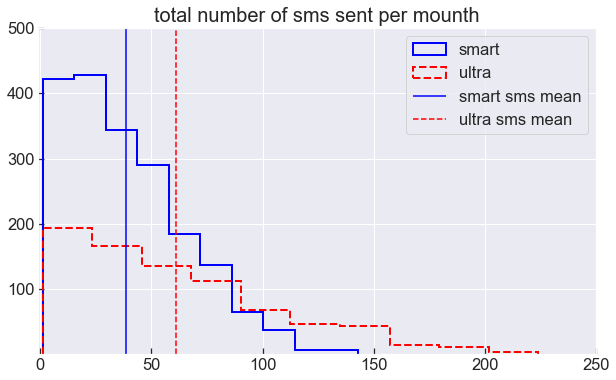

In [87]:
fig, ax = plt.subplots()

ax.hist(smart_sms_stat_df['sms_count'], histtype='step',
        color='blue', lw=2, label='smart')
ax.hist(ultra_sms_stat_df['sms_count'], histtype='step',
        color='red', lw=2, ls='--', label='ultra')

ax.set_title('total number of sms sent per mounth', fontsize=20)

ax.vlines(smart_sms_stat_df['sms_count'].mean(), 0, 1e3, color='blue',
          label='smart sms mean')
ax.vlines(ultra_sms_stat_df['sms_count'].mean(), 0, 1e3, color='red', ls='--',
          label='ultra sms mean')

ax.legend()

ax.set_xlim(-1, 250)
ax.set_ylim(.1, 500)

plt.show()

In [88]:
# Доля пользователей тарифа smart, превышающих лимит по sms

smart_over_limit = smart_sms_stat_df['sms_count'] > smart_sms_limit

smart_over_fraction = len(smart_sms_stat_df[smart_over_limit].index.get_level_values(level='user_id').unique())
smart_over_fraction = smart_over_fraction / len(smart_sms_stat_df.index.get_level_values(level='user_id').unique())

print(f'{smart_over_fraction:.0%}')

41%


In [89]:
mean_var_std(smart_sms_stat_df['sms_count'], smart_sms_limit,
             ultra_sms_stat_df['sms_count'], ultra_sms_limit,
             description='Среднее количество sms, отправленных')

Среднее количество sms, отправленных пользователями тарифа smart в месяц составляет 39 при лимите в 50
Дисперсия: 718
Стандартное отклонение: 27

Среднее количество sms, отправленных пользователями тарифа ultra в месяц составляет 61 при лимите в 1000
Дисперсия: 2110
Стандартное отклонение: 46


- Около 40% поользователей тарифа `smart` выходят за предел количества sms, предусмотренных тарифом. Этого не наблюдается для пользователей тарифа `ultra` --- максимальноее количество sms, отправленных такими пользователями в месяц не превышает 230 (при лимите в 3000 сообщений). В среднем пользователям тарифа `smart` требуется 39 сообщений в месяц, пользователям тарифа `ultra` --- 61 сообщение. Стандартное отклонение для пользователей тарифа `smart` заметно меньше, чем для пользователей тарифа `ultra`.

### 3.3 Веб-трафик по месяцам

In [93]:
smart_web_limit = smart_parameters['mb_per_month_included'].values[0] / 1024
smart_web_overpay = smart_parameters['rub_per_gb'].values[0]

ultra_web_limit = ultra_parameters['mb_per_month_included'].values[0] / 1024
ultra_web_overpay = ultra_parameters['rub_per_gb'].values[0]

In [94]:
user_web_df = users_df[['tariff']].merge(internet_df, left_index=True, right_index=True)

user_web_df.shape

(149396, 5)

In [95]:
smart_web_df = user_web_df[user_web_df['tariff'] == 'smart']
ultra_web_df = user_web_df[user_web_df['tariff'] == 'ultra']

In [96]:
def web_revenue(tarif_web_df, gb_overpay, gb_limit):

    web_stat_df = (
                    tarif_web_df
                    .groupby([tarif_web_df.index, 'month'])['mb_used']
                    .agg(['count', 'sum'])
                  )

    web_stat_df.columns = ['session_count', 'mb_month']

    # Гигабайт использовано в месяц каждым пользователем
    web_stat_df['Gb_count'] = web_stat_df['mb_month'] / 1024

    # Округляю гигабайты в большую сторону и привожу к целочисленному типу
    web_stat_df['Gb_count'] = np.ceil(web_stat_df['Gb_count']).astype(int)

    # Сколько гигабайт осталось?
    web_stat_df['Gb_left'] = web_stat_df['Gb_count'] - gb_limit
    web_left = web_stat_df['Gb_left']

    web_stat_df['Gb_overpay'] = np.where(web_left < 0, web_left, 0)
    web_stat_df['Gb_overpay'] = web_stat_df['Gb_overpay'].abs()

    # Сколько пользователь переплатит за интернет?
    web_stat_df['Gb_overpay'] = web_stat_df['Gb_overpay'] * gb_overpay
    web_stat_df['Gb_overpay'] = web_stat_df['Gb_overpay'].astype(int)

    return web_stat_df

In [97]:
smart_web_stat_df = web_revenue(tarif_web_df=smart_web_df,
                                gb_overpay=smart_web_overpay,
                                gb_limit=smart_web_limit)

ultra_web_stat_df = web_revenue(tarif_web_df=ultra_web_df,
                                gb_overpay=ultra_web_overpay,
                                gb_limit=ultra_web_limit)

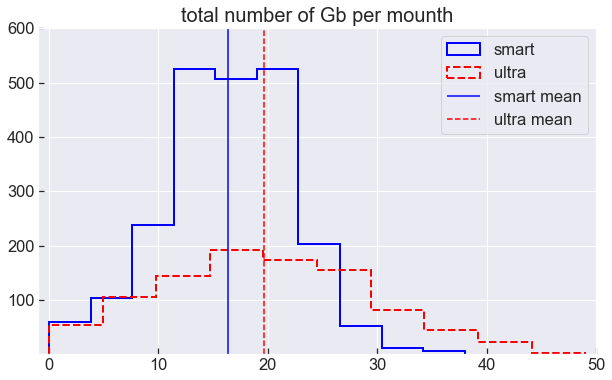

In [98]:
fig, ax = plt.subplots()

# space = np.linspace(0, 1750, 15)

ax.hist(smart_web_stat_df['Gb_count'], histtype='step',
        color='blue', lw=2, label='smart')
ax.hist(ultra_web_stat_df['Gb_count'], histtype='step',
        color='red', lw=2, ls='--', label='ultra')

ax.set_title('total number of Gb per mounth', fontsize=20)

ax.vlines(smart_web_stat_df['Gb_count'].mean(), 0, 1e3, color='blue',
          label='smart mean')
ax.vlines(ultra_web_stat_df['Gb_count'].mean(), 0, 1e3, color='red', ls='--',
          label='ultra mean')

ax.legend()

ax.set_xlim(-1, 50)
ax.set_ylim(.1, 600)

plt.show()

In [99]:
mean_var_std(smart_web_stat_df['Gb_count'], smart_web_limit,
             ultra_web_stat_df['Gb_count'], ultra_web_limit,
             description='Средний объем трафика (в Гб), использованного')

Средний объем трафика (в Гб), использованного пользователями тарифа smart в месяц составляет 16 при лимите в 15.0
Дисперсия: 33
Стандартное отклонение: 6

Средний объем трафика (в Гб), использованного пользователями тарифа ultra в месяц составляет 20 при лимите в 30.0
Дисперсия: 94
Стандартное отклонение: 10


- Среди пользователей обоих тарифов есть пользователи, которые превышают ограничения по трафику. В среднем пользователям тарифа `smart` требуется 16 Гб в месяц, пользователям тарифа `ultra` --- 20 Гб. Для пользователей тарифа `smart` стандартное отклонение заметно меньше, чем для для пользователей тарифа `ultra`.

### 3.4 Общая выручка по месяцам

In [100]:
from functools import reduce
pd.options.display.float_format = "{:.1f}".format

In [101]:
smart_overpay_list = [smart_calls_stat_df['call_overpay'], smart_sms_stat_df['sms_overpay'], smart_web_stat_df['Gb_overpay']]
ultra_overpay_list = [ultra_calls_stat_df['call_overpay'], ultra_sms_stat_df['sms_overpay'], ultra_web_stat_df['Gb_overpay']]

In [102]:
smart_count_list = [smart_calls_stat_df['call_duration'], smart_sms_stat_df['sms_count'], smart_web_stat_df['Gb_count']]
ultra_count_list = [ultra_calls_stat_df['call_duration'], ultra_sms_stat_df['sms_count'], ultra_web_stat_df['Gb_count']]

In [113]:
def merger(df_list, stat=False, stat_colname='total_overpay'):

    merged_dfs = reduce(lambda  left,right: pd.merge(left, right, left_index=True,
                                                     right_index=True, how='outer'),
                                                     df_list)

    if stat:
        merged_dfs[stat_colname] = merged_dfs.sum(axis=1)

    return merged_dfs

In [118]:
# Абонентская плата
smart_fee = smart_parameters['rub_monthly_fee'].values[0]
ultra_fee = ultra_parameters['rub_monthly_fee'].values[0]

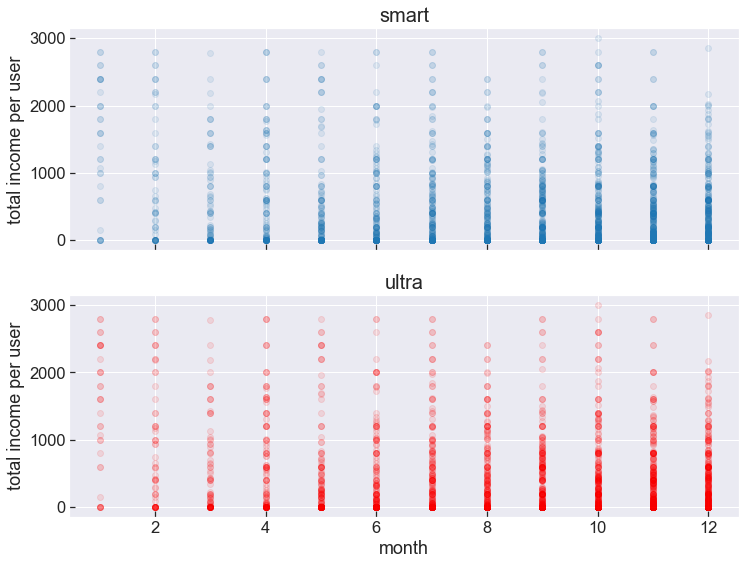

In [159]:
smart_overpay_dfs_merged = merger(smart_overpay_list, stat=True)
ultra_overpay_dfs_merged = merger(ultra_overpay_list, stat=True)

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(12,9), sharex=True)

ax.scatter(smart_overpay_dfs_merged.index.get_level_values(level='month'),
           smart_overpay_dfs_merged['total_overpay'], alpha=.1)

# ax.set_xlabel('month')
ax.set_ylabel('total income per user')
ax.set_title('smart', fontsize=20)

ax1.scatter(smart_overpay_dfs_merged.index.get_level_values(level='month'),
            smart_overpay_dfs_merged['total_overpay'], alpha=.1, color='red')

ax1.set_xlabel('month')
ax1.set_ylabel('total income per user')
ax1.set_title('ultra', fontsize=20)

plt.show()

- Можно видеть, что для первых нескольких месяцев достаточно мало точек и отсутствуют "тяжелые хвосты" внизу. Отсюда относительно большие средние значения:

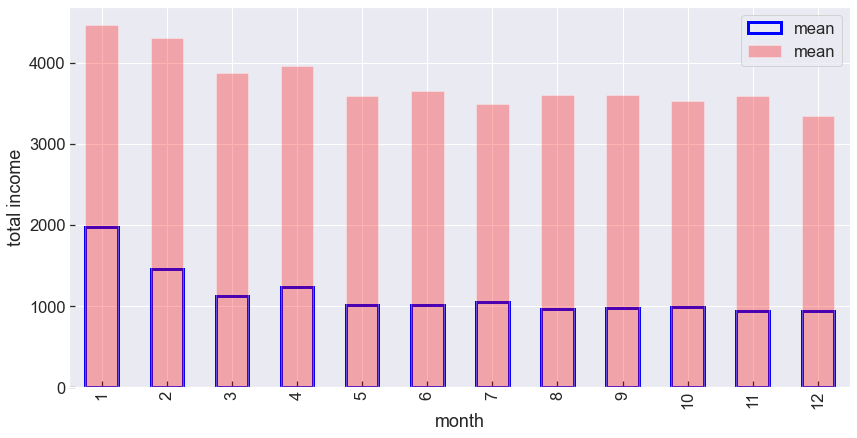

In [161]:
fig, ax = plt.subplots(figsize=(14,7))

smart_overpay_dfs_merged['smart_income'] = smart_overpay_dfs_merged['total_overpay'] + smart_fee
smart_overpay_dfs_merged.groupby(level=1)['smart_income'].agg(['mean']).plot(kind='bar', color='none',
                                                                               edgecolor='blue', lw=3, ax=ax,
                                                                               label='smart_median')

ultra_overpay_dfs_merged['ultra_income'] = ultra_overpay_dfs_merged['total_overpay'] + ultra_fee
ultra_overpay_dfs_merged.groupby(level=1)['ultra_income'].agg(['mean']).plot(kind='bar', color='red', alpha=.3,
                                                                               ax=ax, label='ultra')

ax.legend()
ax.set_ylabel('total income')

plt.show()

In [135]:
smart_count_dfs_merged = merger(smart_count_list)

smart_month_stat = smart_count_dfs_merged.groupby(level=1).agg(['mean', 'var', 'std', 'count'])

smart_month_stat

call_duration                     sms_count                  Gb_count  \
               mean     var   std count      mean   var  std count     mean   
month                                                                         
1             203.9 23787.3 154.2    34      20.0 252.1 15.9    31      8.7   
2             298.7 36412.3 190.8    58      27.9 440.5 21.0    50     11.8   
3             390.1 36823.2 191.9    77      35.6 669.8 25.9    69     15.2   
4             367.1 34778.2 186.5   112      35.9 517.9 22.8    96     13.6   
5             387.4 34820.1 186.6   141      39.0 638.8 25.3   122     15.9   
6             398.1 29960.5 173.1   163      38.6 731.6 27.0   142     16.0   
7             408.4 32250.3 179.6   201      39.0 719.4 26.8   174     15.9   
8             423.3 34177.3 184.9   234      38.8 767.2 27.7   204     16.8   
9             430.3 32950.5 181.5   259      39.2 702.5 26.5   223     16.4   
10            427.6 34889.5 186.8   293      39.1 736.5 27.1   254     16.9   
11            436.6 31100.6 176.4   315      39.9 711.4 26.7   270     17.0   
12            480.0 39131.4 197.8   336      42.3 832.4 28.9   287     18.2   

                      
       var std count  
month                 
1     39.4 6.3    34  
2     37.2 6.1    58  
3     32.5 5.7    77  
4     31.3 5.6   112  
5     34.4 5.9   141  
6     31.9 5.6   164  
7     33.4 5.8   201  
8     29.0 5.4   234  
9     25.9 5.1   260  
10    32.9 5.7   294  
11    27.2 5.2   316  
12    29.8 5.5   337

In [136]:
ultra_count_dfs_merged = merger(ultra_count_list)

ultra_month_stat = ultra_count_dfs_merged.groupby(level=1).agg(['mean', 'var', 'std', 'count'])

ultra_month_stat

call_duration                      sms_count                   Gb_count  \
               mean      var   std count      mean    var  std count     mean   
month                                                                           
1             428.1  72769.4 269.8     9      43.4  765.3 27.7     7     13.2   
2             297.1  87919.7 296.5    24      32.9  713.4 26.7    16     13.1   
3             489.6 111384.9 333.7    37      47.8 1826.7 42.7    25     17.6   
4             475.3  66036.8 257.0    53      44.5 1408.3 37.5    39     17.0   
5             534.2  74881.0 273.6    64      48.8 1559.6 39.5    52     19.7   
6             497.5  86019.7 293.3    81      52.3 1935.7 44.0    67     19.2   
7             564.4  86952.6 294.9    88      62.1 2190.7 46.8    73     20.7   
8             530.6  91169.6 301.9   103      58.9 2023.0 45.0    88     19.8   
9             558.9  98597.9 314.0   111      63.3 1906.8 43.7    95     19.4   
10            581.7  97140.3 311.7   118      69.8 2426.6 49.3   103     20.2   
11            562.4  88449.6 297.4   129      66.2 2249.3 47.4   113     20.0   
12            614.9 107981.0 328.6   134      72.0 2362.9 48.6   117     21.9   

                        
        var  std count  
month                   
1      44.4  6.7     9  
2     104.6 10.2    22  
3     114.3 10.7    37  
4      89.4  9.5    55  
5      91.2  9.6    66  
6      79.0  8.9    83  
7      92.7  9.6    90  
8     102.5 10.1   106  
9      83.7  9.1   114  
10     88.7  9.4   122  
11     91.5  9.6   133  
12    100.5 10.0   138

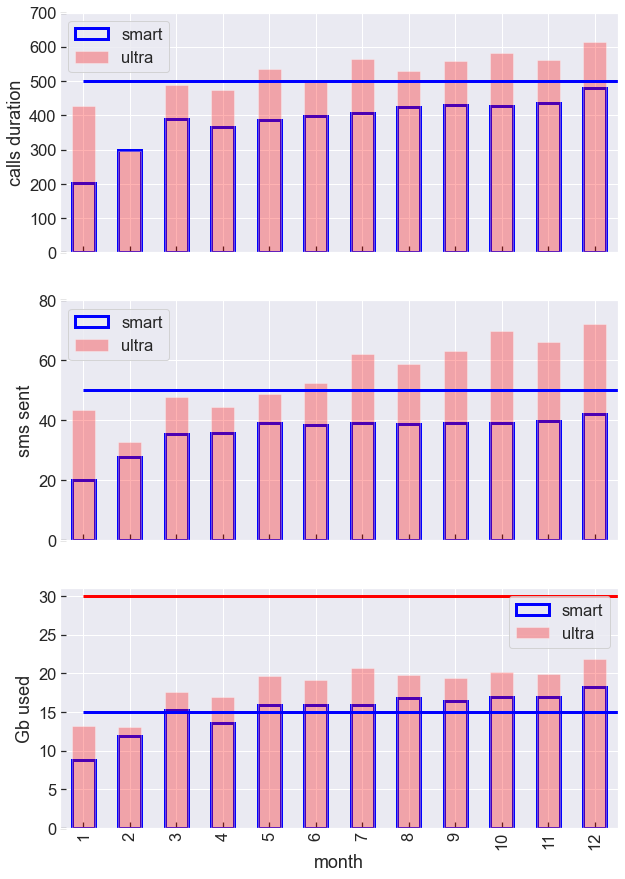

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,15), sharex=True)

smart_month_stat['call_duration']['mean'].plot(kind='bar', color='none', edgecolor='blue',
                                             lw=3, ax=ax1, label='smart')
ultra_month_stat['call_duration']['mean'].plot(kind='bar', color='red', alpha=.3, ax=ax1, label='ultra')
ax1.set_ylabel('calls duration')
ax1.hlines(smart_minutes_limit, 0, 12, lw=3, color='blue')
ax1.hlines(ultra_minutes_limit, 0, 12, lw=3, color='red')
ax1.legend()
ax1.set_ylim(0, 700)

smart_month_stat['sms_count']['mean'].plot(kind='bar', color='none', edgecolor='blue',
                                           lw=3, ax=ax2, label='smart')
ultra_month_stat['sms_count']['mean'].plot(kind='bar', color='red', alpha=.3, ax=ax2, label='ultra')
ax2.set_ylabel('sms sent')
ax2.hlines(smart_sms_limit, 0, 12, lw=3, color='blue')
ax2.hlines(ultra_sms_limit, 0, 12, lw=3, color='red')
ax2.legend()
ax2.set_ylim(0, 80)

smart_month_stat['Gb_count']['mean'].plot(kind='bar', color='none', edgecolor='blue',
                                          lw=3, ax=ax3, label='smart')
ultra_month_stat['Gb_count']['mean'].plot(kind='bar', color='red', alpha=.3, ax=ax3, label='ultra')
ax3.set_ylabel('Gb used')
ax3.hlines(smart_web_limit, 0, 12, lw=3, color='blue')
ax3.hlines(ultra_web_limit, 0, 12, lw=3, color='red')
ax3.legend()
ax3.set_ylim(0, 31)

plt.show()

- Во всех трех категориях наблюдается тенденция к росту объема использованных услуг с течением времени.

- Наиболее выражена эта тенденция для пользователей тарифа `ultra` (особенно для статистики по отправленным sms). Для этой категории использование константы при описании данных может оказаться некорректным.

- Пользователи тарифа `ultra` (в среднем) приближаются к лимиту только по количеству использованного веб-трафика. Для двух остальных категорий услуг лимиты по тарифу `ultra` не указаны на графиках для удобства восприятия.